<a href="https://colab.research.google.com/github/sriram2k4/BreastCancerLogisticRegression/blob/main/steganography_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## to ignore all the warning
import warnings

warnings.filterwarnings('ignore')

In [2]:
# import the image net data set
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2025-02-17 08:08:03--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs231n.stanford.edu/tiny-imagenet-200.zip [following]
--2025-02-17 08:08:03--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  6.09MB/s    in 45s     

2025-02-17 08:08:49 (5.25 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [5]:
#BackUp for ImageDataset - Run this if there is issue while downloading
#!wget https://www.dropbox.com/s/jd673ol7dhaaiux/tiny-imagenet-200.zip

In [3]:
# Unzipping of our data set & Delete the Zip File

!unzip /content/tiny-imagenet-200.zip
!rm /content/tiny-imagenet-200.zip

Streaming output truncated to the last 5000 lines.
  inflating: tiny-imagenet-200/val/images/val_3979.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9241.JPEG  
  inflating: tiny-imagenet-200/val/images/val_4196.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5980.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6697.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9969.JPEG  
  inflating: tiny-ima

In [4]:
### Imports ###
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt

import numpy as np
import os
import random
import scipy.misc
from tqdm import *

In [5]:
### Constants ###
DATA_DIR = "/content/tiny-imagenet-200"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")
IMG_SHAPE = (64, 64)


#Dataset creation
The Dataset we used is Tiny ImageNet Visual Recognition Challenge.

Our training set is made of a random subset of images from all 200 classes.

In [6]:
def load_dataset_small(num_images_per_class_train=10, num_images_test=500):
    """Loads training and test datasets, from Tiny ImageNet Visual Recogition Challenge.

    Arguments:
        num_images_per_class_train: number of images per class to load into training dataset.
        num_images_test: total number of images to load into training dataset.
    """
    X_train = []
    X_test = []

    # Create training set.
    for c in os.listdir(TRAIN_DIR):
        c_dir = os.path.join(TRAIN_DIR, c, 'images')
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        for img_name_i in c_imgs[0:num_images_per_class_train]:
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            x = image.img_to_array(img_i)
            X_train.append(x)
    random.shuffle(X_train)

    # Create test set.
    test_dir = os.path.join(TEST_DIR, 'images')
    test_imgs = os.listdir(test_dir)
    random.shuffle(test_imgs)
    for img_name_i in test_imgs[0:num_images_test]:
        img_i = image.load_img(os.path.join(test_dir, img_name_i))
        x = image.img_to_array(img_i)
        X_test.append(x)

    # Return train and test data as numpy arrays.
    return np.array(X_train), np.array(X_test)

In [7]:
# Load dataset.
X_train_orig, X_test_orig = load_dataset_small()

# Normalize image vectors.
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Print statistics.
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape)) # Should be (train_size, 64, 64, 3)

Number of training examples = 2000
Number of test examples = 500
X_train shape: (2000, 64, 64, 3)


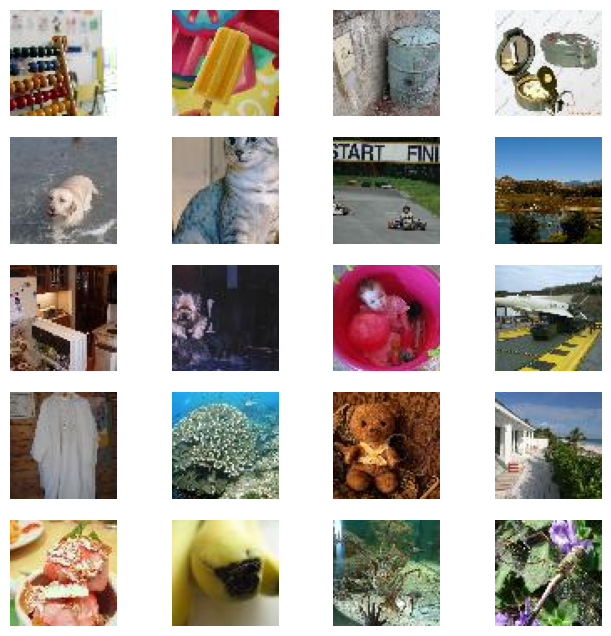

In [8]:
# Show sample images from the training dataset
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # Randomly sample from training dataset
    img_idx = np.random.choice(X_train.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.axis("off")
    plt.imshow(X_train[img_idx])
plt.show()

In [9]:
# We split training set into two halfs.
# First half is used for training as secret images, second half for cover images.
# S: secret image
input_S = X_train[0:X_train.shape[0] // 2]
# C: cover image
input_C = X_train[X_train.shape[0] // 2:]

## Project Agenda

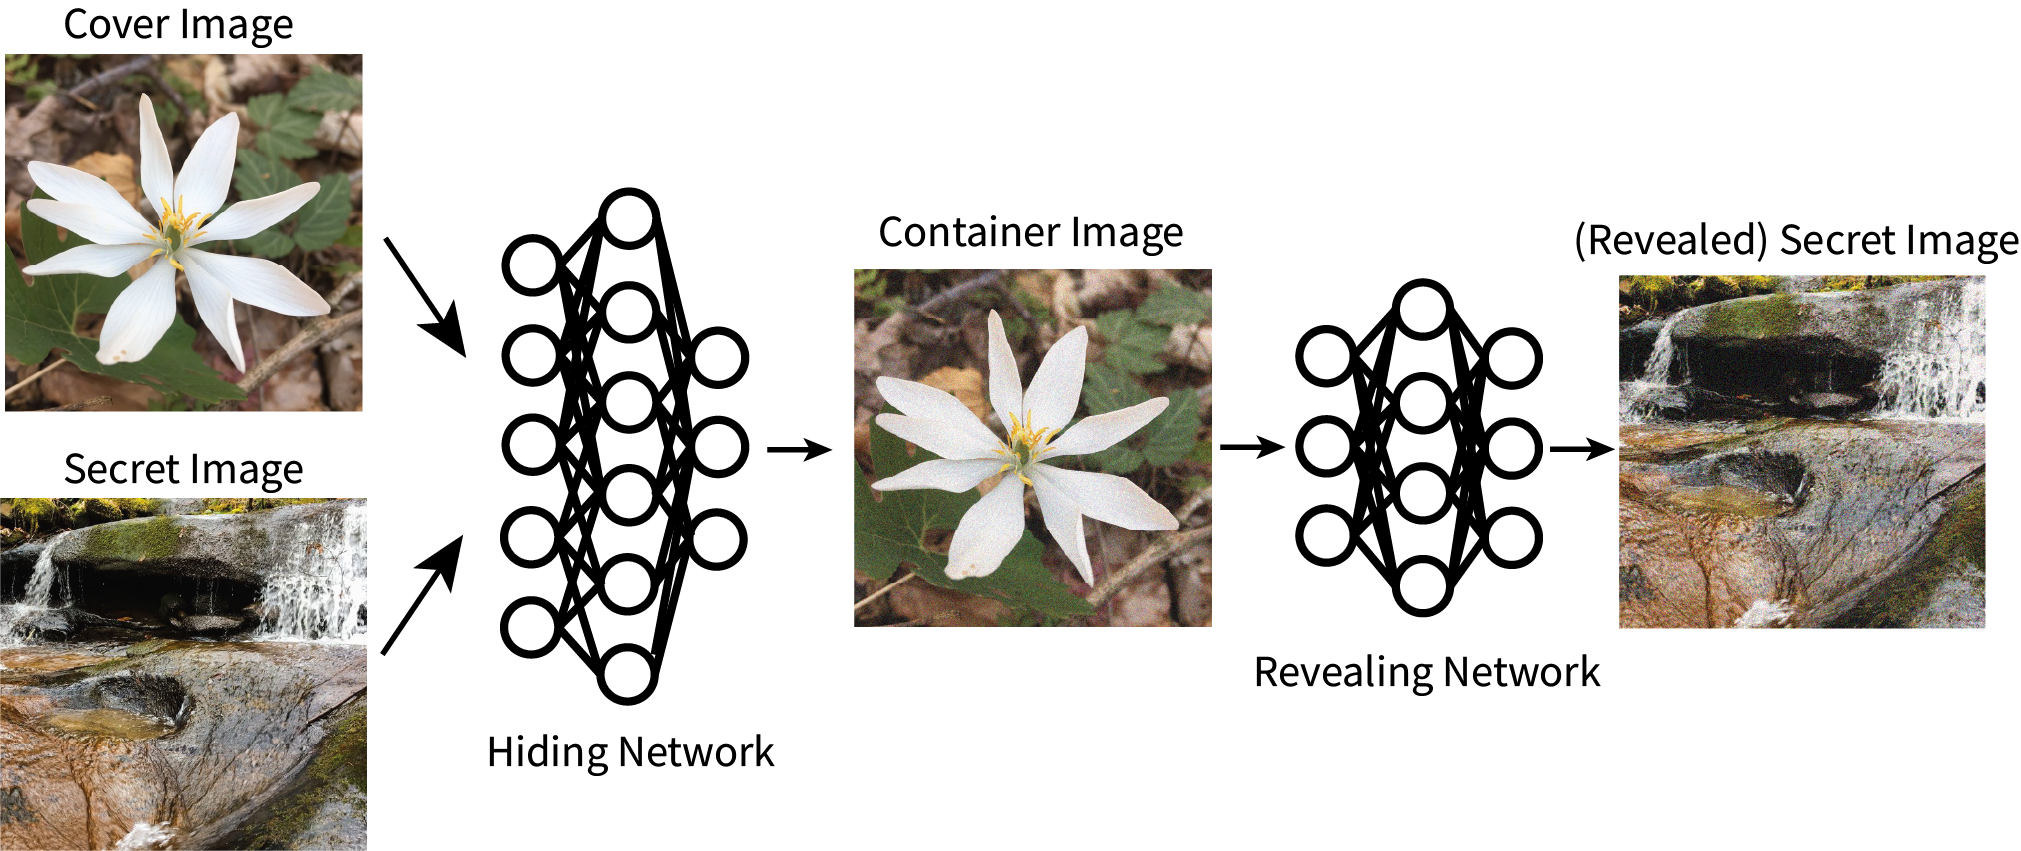

# Description
The model is composed of three parts: The Preparation Network, Hiding Network (Encoder) and the Reveal Network.

The goal is to be able to encode information about the secret image S into the cover image C, generating C' that closely resembles C, while still being able to decode information from C' to generate the decoded secret image S', which should resemble S as closely as possible.

The Preparation Network has the responsibility of preparing data from the secret image to be concatenated with the cover image and fed to the Hiding Network. The Hiding Network than transforms that input into the encoded cover image C'. Finally, the Reveal Network decodes the secret image S' from C'.

For stability, we add noise before the Reveal Network(reference through some paper paper). Although the author of the paper didn't originally specify the architecture of the three networks.

For both the Hiding and Reveal networks, we use 5 layers of 65 filters (50 3x3 filters, 10 4x4 filters and 5 5x5 filters). For the preparation network, we use only 2 layers with the same structure.


## Deep steganography Model Architecture

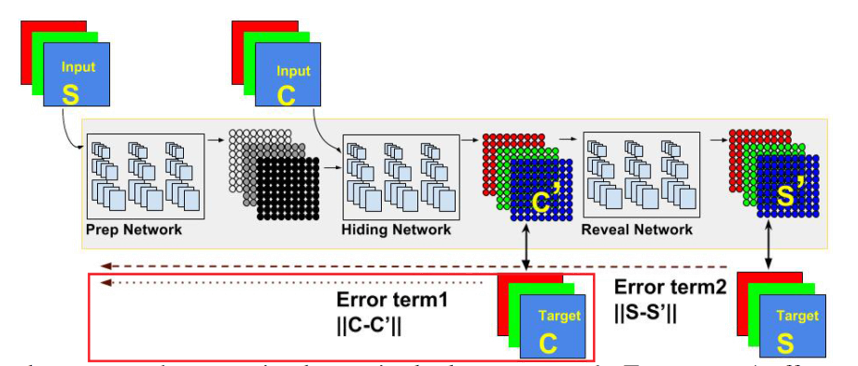

In [10]:
beta = 1.0

# Loss for reveal network
def rev_loss(s_true, s_pred):
    # Loss for reveal network is: beta * |S-S'|
    return beta * K.sum(K.square(s_true - s_pred))

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[...,0:3], y_true[...,3:6]
    s_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6]

    s_loss = rev_loss(s_true, s_pred)
    c_loss = K.sum(K.square(c_true - c_pred))
    return s_loss + c_loss

In [11]:
# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.

def make_encoder(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))

    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(input_S)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(input_S)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(input_S)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])

    x = concatenate([input_C, x])

    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])

    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)

    return Model(inputs=[input_S, input_C],
                 outputs=output_Cprime,
                 name = 'Encoder')

In [12]:
# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):

    # Reveal network
    reveal_input = Input(shape=(input_size))

    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input)

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(input_with_noise)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])

    output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='tanh', name='output_S')(x)

    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_Sprime,
                     name = 'Decoder')
    else:
        return Network(inputs=reveal_input,
                         outputs=output_Sprime,
                         name = 'DecoderFixed')


In [13]:
# Full model.
def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))

    encoder = make_encoder(input_size)

    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False

    output_Cprime = encoder([input_S, input_C])
    output_Sprime = decoder(output_Cprime)

    autoencoder = Model(inputs=[input_S, input_C],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)

    return encoder, decoder, autoencoder

In [14]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 400:
        return 0.0003
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00003

In [15]:
def train(e, lr=0.001):
    NB_EPOCHS = e
    BATCH_SIZE = 32

    encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])

    # Directly set the learning rate for both optimizers
    autoencoder_model.optimizer.learning_rate = lr
    reveal_model.optimizer.learning_rate = lr

    m = input_S.shape[0]
    loss_history = []

    for epoch in range(NB_EPOCHS):
        np.random.shuffle(input_S)
        np.random.shuffle(input_C)
        t = tqdm(range(0, input_S.shape[0], BATCH_SIZE), mininterval=0)

        ae_loss = []
        rev_loss = []

        for idx in t:
            batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
            batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]

            C_prime = encoder_model.predict([batch_S, batch_C])
            aeLoss = autoencoder_model.train_on_batch(x=[batch_S, batch_C],
                                                      y=np.concatenate((batch_S, batch_C), axis=3))
            ae_loss.append(aeLoss)

            revLoss = reveal_model.train_on_batch(x=C_prime, y=batch_S)
            rev_loss.append(revLoss)

            t.set_description('Epoch {} | Loss AE {:10.2f} | Loss Rev {:10.2f} | lr {}'.format(
                epoch + 1, np.mean(ae_loss), np.mean(rev_loss), lr))

        lr = lr_schedule(epoch + 1)
        mean_ae_loss = np.mean(ae_loss)
        loss_history.append(mean_ae_loss)

    autoencoder_model.save_weights('./model_weights.weights.h5')
    autoencoder_model.save("model.h5")

    return loss_history, autoencoder_model

In [16]:
loss_history, autoencoder_model = train(2) # train funtion takes number of epochs as a input as i have traied my model for 1000 epochs i have saved the weights

  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Epoch 1 | Loss AE  191776.69 | Loss Rev   92085.74 | lr 0.001:   3%|▎         | 1/32 [00:20<10:34, 20.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Epoch 1 | Loss AE  189930.69 | Loss Rev   95047.14 | lr 0.001:   6%|▋         | 2/32 [00:20<04:20,  8.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 1 | Loss AE  185805.20 | Loss Rev   95273.79 | lr 0.001:   9%|▉         | 3/32 [00:21<02:20,  4.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 1 | Loss AE  181892.11 | Loss Rev   95223.75 | lr 0.001:  12%|█▎        | 4/32 [00:21<01:25,  3.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 1 | Loss AE  178278.25 | Loss Rev   95500.80 | lr 0.001:  16%|█▌        | 5/32 [00:21<00:56,  2.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 1 | Loss AE  174918.73 | Loss Rev   96140.18 | lr 0.001:  19%|█▉        | 6/32 [00:22<00:38,  1.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 1 | Loss AE  171490.78 | Loss Rev   96366.84 | lr 0.001:  22%|██▏       | 7/32 [00:22<00:27,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 1 | Loss AE  168404.00 | Loss Rev   96634.46 | lr 0.001:  25%|██▌       | 8/32 [00:22<00:20,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 1 | Loss AE  165703.00 | Loss Rev   96950.66 | lr 0.001:  28%|██▊       | 9/32 [00:23<00:15,  1.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 1 | Loss AE  163382.58 | Loss Rev   97350.54 | lr 0.001:  31%|███▏      | 10/32 [00:23<00:12,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 1 | Loss AE  161299.39 | Loss Rev   97734.72 | lr 0.001:  34%|███▍      | 11/32 [00:23<00:10,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 1 | Loss AE  159377.33 | Loss Rev   98059.27 | lr 0.001:  38%|███▊      | 12/32 [00:24<00:08,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 1 | Loss AE  157609.41 | Loss Rev   98341.41 | lr 0.001:  41%|████      | 13/32 [00:24<00:07,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 1 | Loss AE  155949.88 | Loss Rev   98552.68 | lr 0.001:  44%|████▍     | 14/32 [00:24<00:06,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 1 | Loss AE  154405.66 | Loss Rev   98728.03 | lr 0.001:  47%|████▋     | 15/32 [00:24<00:06,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 1 | Loss AE  152949.62 | Loss Rev   98851.53 | lr 0.001:  50%|█████     | 16/32 [00:25<00:05,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 1 | Loss AE  151553.48 | Loss Rev   98918.76 | lr 0.001:  53%|█████▎    | 17/32 [00:25<00:05,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 1 | Loss AE  150272.69 | Loss Rev   98995.73 | lr 0.001:  56%|█████▋    | 18/32 [00:25<00:04,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 1 | Loss AE  149107.31 | Loss Rev   99098.44 | lr 0.001:  59%|█████▉    | 19/32 [00:26<00:04,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 1 | Loss AE  148018.84 | Loss Rev   99191.16 | lr 0.001:  62%|██████▎   | 20/32 [00:26<00:03,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 1 | Loss AE  146979.55 | Loss Rev   99258.02 | lr 0.001:  66%|██████▌   | 21/32 [00:26<00:03,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 1 | Loss AE  145997.72 | Loss Rev   99312.62 | lr 0.001:  69%|██████▉   | 22/32 [00:27<00:03,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 1 | Loss AE  145063.20 | Loss Rev   99351.91 | lr 0.001:  72%|███████▏  | 23/32 [00:27<00:02,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 1 | Loss AE  144178.58 | Loss Rev   99385.21 | lr 0.001:  75%|███████▌  | 24/32 [00:27<00:02,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 1 | Loss AE  143320.48 | Loss Rev   99395.34 | lr 0.001:  78%|███████▊  | 25/32 [00:28<00:02,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Epoch 1 | Loss AE  142501.56 | Loss Rev   99401.03 | lr 0.001:  81%|████████▏ | 26/32 [00:28<00:02,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Epoch 1 | Loss AE  141716.47 | Loss Rev   99399.44 | lr 0.001:  84%|████████▍ | 27/32 [00:28<00:01,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Epoch 1 | Loss AE  140963.47 | Loss Rev   99391.06 | lr 0.001:  88%|████████▊ | 28/32 [00:29<00:01,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Epoch 1 | Loss AE  140245.47 | Loss Rev   99383.33 | lr 0.001:  91%|█████████ | 29/32 [00:29<00:01,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Epoch 1 | Loss AE  139541.39 | Loss Rev   99355.84 | lr 0.001:  94%|█████████▍| 30/32 [00:30<00:00,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Epoch 1 | Loss AE  138873.56 | Loss Rev   99334.46 | lr 0.001:  97%|█████████▋| 31/32 [00:30<00:00,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Epoch 1 | Loss AE  138222.70 | Loss Rev   99294.38 | lr 0.001: 100%|██████████| 32/32 [00:42<00:00,  1.34s/it]
  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Epoch 2 | Loss AE  117545.75 | Loss Rev   97948.02 | lr 0.001:   3%|▎         | 1/32 [00:00<00:11,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 2 | Loss AE  117177.28 | Loss Rev   97745.12 | lr 0.001:   6%|▋         | 2/32 [00:00<00:09,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 2 | Loss AE  116965.97 | Loss Rev   97721.94 | lr 0.001:   9%|▉         | 3/32 [00:00<00:09,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 2 | Loss AE  116713.97 | Loss Rev   97651.93 | lr 0.001:  12%|█▎        | 4/32 [00:01<00:08,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 2 | Loss AE  116534.15 | Loss Rev   97648.91 | lr 0.001:  16%|█▌        | 5/32 [00:01<00:08,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 2 | Loss AE  116334.65 | Loss Rev   97620.02 | lr 0.001:  19%|█▉        | 6/32 [00:01<00:08,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 2 | Loss AE  116113.55 | Loss Rev   97567.69 | lr 0.001:  22%|██▏       | 7/32 [00:02<00:07,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 2 | Loss AE  115911.88 | Loss Rev   97533.16 | lr 0.001:  25%|██▌       | 8/32 [00:02<00:07,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Epoch 2 | Loss AE  115715.59 | Loss Rev   97499.20 | lr 0.001:  28%|██▊       | 9/32 [00:02<00:07,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 2 | Loss AE  115546.41 | Loss Rev   97490.89 | lr 0.001:  31%|███▏      | 10/32 [00:03<00:06,  3.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 2 | Loss AE  115383.02 | Loss Rev   97485.45 | lr 0.001:  34%|███▍      | 11/32 [00:03<00:06,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 2 | Loss AE  115244.09 | Loss Rev   97498.85 | lr 0.001:  38%|███▊      | 12/32 [00:03<00:06,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 2 | Loss AE  115101.30 | Loss Rev   97505.54 | lr 0.001:  41%|████      | 13/32 [00:04<00:06,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 2 | Loss AE  114969.02 | Loss Rev   97518.37 | lr 0.001:  44%|████▍     | 14/32 [00:04<00:05,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 2 | Loss AE  114846.40 | Loss Rev   97537.42 | lr 0.001:  47%|████▋     | 15/32 [00:04<00:05,  3.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Epoch 2 | Loss AE  114715.67 | Loss Rev   97544.23 | lr 0.001:  50%|█████     | 16/32 [00:05<00:05,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 2 | Loss AE  114573.59 | Loss Rev   97536.70 | lr 0.001:  53%|█████▎    | 17/32 [00:05<00:04,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 2 | Loss AE  114446.30 | Loss Rev   97540.93 | lr 0.001:  56%|█████▋    | 18/32 [00:05<00:04,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Epoch 2 | Loss AE  114326.84 | Loss Rev   97550.00 | lr 0.001:  59%|█████▉    | 19/32 [00:06<00:04,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


Epoch 2 | Loss AE  114199.92 | Loss Rev   97547.88 | lr 0.001:  62%|██████▎   | 20/32 [00:06<00:04,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Epoch 2 | Loss AE  114080.69 | Loss Rev   97551.19 | lr 0.001:  66%|██████▌   | 21/32 [00:06<00:03,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Epoch 2 | Loss AE  113972.15 | Loss Rev   97562.13 | lr 0.001:  69%|██████▉   | 22/32 [00:07<00:03,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 2 | Loss AE  113862.72 | Loss Rev   97570.55 | lr 0.001:  72%|███████▏  | 23/32 [00:07<00:03,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Epoch 2 | Loss AE  113750.72 | Loss Rev   97573.69 | lr 0.001:  75%|███████▌  | 24/32 [00:07<00:02,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Epoch 2 | Loss AE  113632.81 | Loss Rev   97568.84 | lr 0.001:  78%|███████▊  | 25/32 [00:08<00:02,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 2 | Loss AE  113518.92 | Loss Rev   97565.95 | lr 0.001:  81%|████████▏ | 26/32 [00:08<00:02,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Epoch 2 | Loss AE  113413.00 | Loss Rev   97568.55 | lr 0.001:  84%|████████▍ | 27/32 [00:08<00:01,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Epoch 2 | Loss AE  113304.58 | Loss Rev   97566.02 | lr 0.001:  88%|████████▊ | 28/32 [00:09<00:01,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 2 | Loss AE  113198.50 | Loss Rev   97563.84 | lr 0.001:  91%|█████████ | 29/32 [00:09<00:00,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Epoch 2 | Loss AE  113102.86 | Loss Rev   97569.88 | lr 0.001:  94%|█████████▍| 30/32 [00:09<00:00,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Epoch 2 | Loss AE  113007.35 | Loss Rev   97573.94 | lr 0.001:  97%|█████████▋| 31/32 [00:10<00:00,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 2 | Loss AE  112907.84 | Loss Rev   97569.15 | lr 0.001: 100%|██████████| 32/32 [00:10<00:00,  3.05it/s]


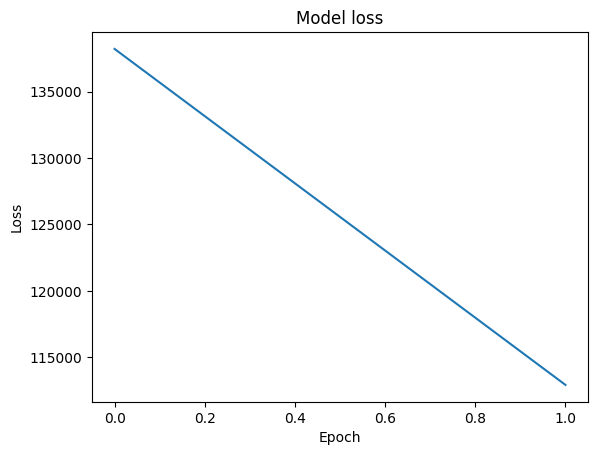

In [17]:
# Plot loss through epochs
plt.plot(loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
from keras.models import load_model

In [18]:
# Load model

autoencoder_model.load_weights('/content/model_weights.weights.h5')

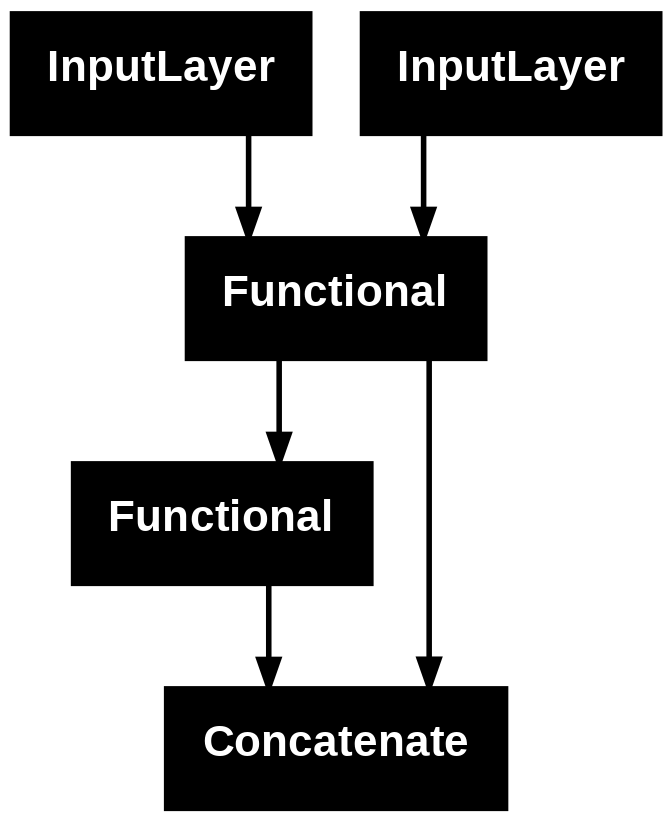

In [19]:
import tensorflow as tf
tf.keras.utils.plot_model(autoencoder_model)

In [20]:
# Retrieve decoded predictions.
decoded = autoencoder_model.predict([input_S, input_C])
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]

# Get absolute difference between the outputs and the expected values.
diff_S, diff_C = np.abs(decoded_S - input_S), np.abs(decoded_C - input_C)

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step


In [21]:
def pixel_errors(input_S, input_C, decoded_S, decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    see_Spixel = np.sqrt(np.mean(np.square(255*(input_S - decoded_S))))
    see_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))

    return see_Spixel, see_Cpixel

def pixel_histogram(diff_S, diff_C):
    """Calculates histograms of errors for cover and secret image. """
    diff_Sflat = diff_S.flatten()
    diff_Cflat = diff_C.flatten()

    fig = plt.figure(figsize=(15, 5))
    a=fig.add_subplot(1,2,1)

    imgplot = plt.hist(255* diff_Cflat, 100, normed=1, alpha=0.75, facecolor='red')
    a.set_title('Distribution of error in the Cover image.')
    plt.axis([0, 250, 0, 0.2])

    a=fig.add_subplot(1,2,2)
    imgplot = plt.hist(255* diff_Sflat, 100, normed=1, alpha=0.75, facSecolor='red')
    a.set_title('Distribution of errors in the Secret image.')
    plt.axis([0, 250, 0, 0.2])

    plt.show()

In [22]:
# Print pixel-wise average errors in a 256 scale.
S_error, C_error = pixel_errors(input_S, input_C, decoded_S, decoded_C)

print ("S error per pixel [0, 255]:", S_error)
print ("C error per pixel [0, 255]:", C_error)

S error per pixel [0, 255]: 126.15684
C error per pixel [0, 255]: 28.669542


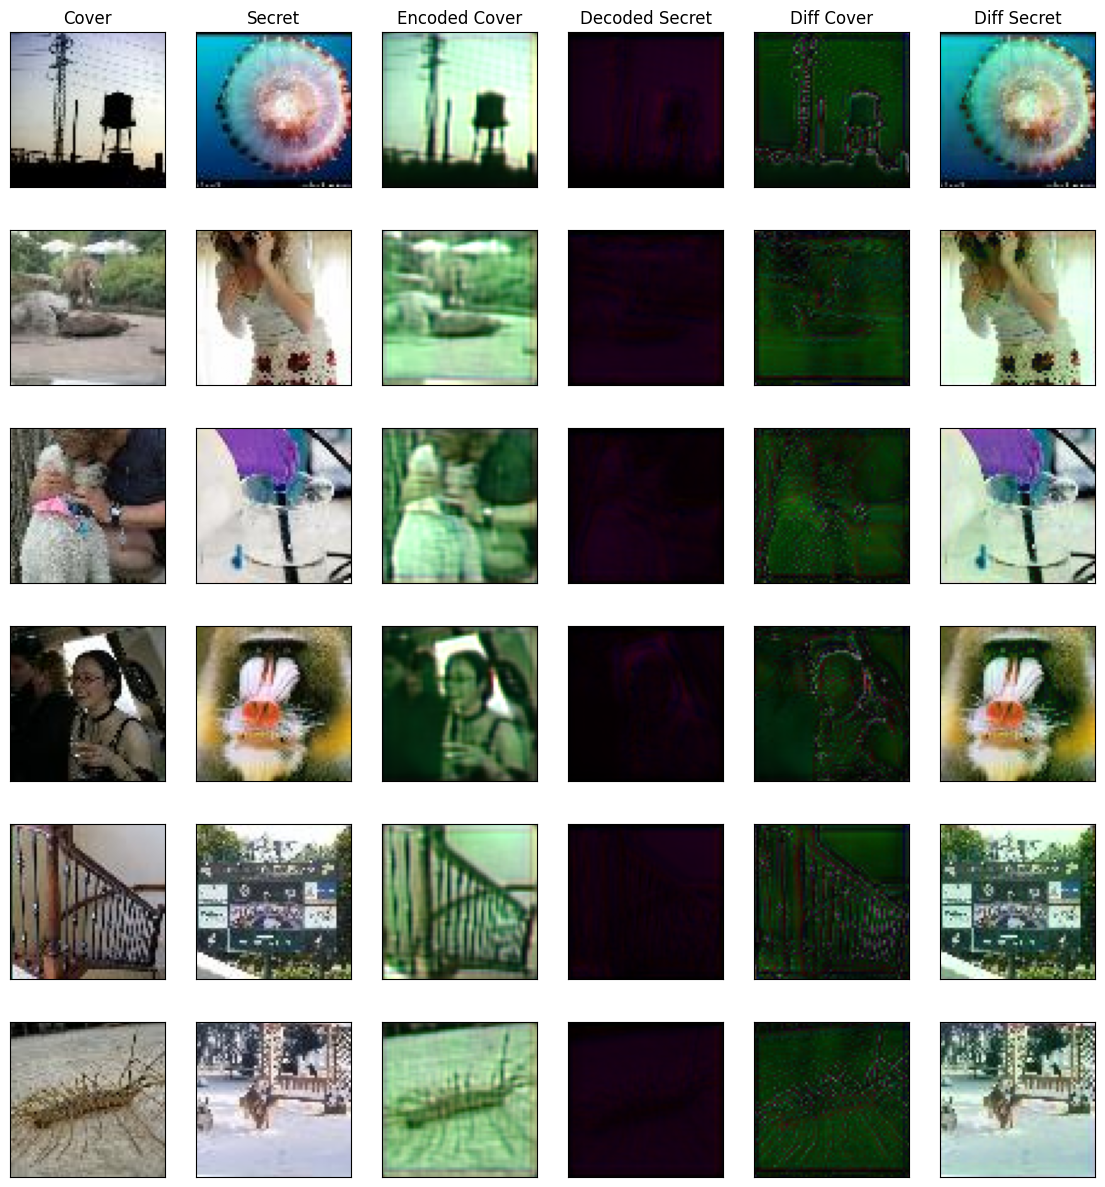

In [23]:
# Configs for results display

# Show images in gray scale
SHOW_GRAY = False
# Show difference bettwen predictions and ground truth.
SHOW_DIFF = True

# Diff enhance magnitude
ENHANCE = 1

# Number of secret and cover pairs to show.
n = 6

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)

plt.figure(figsize=(14, 15))
rand_indx = [random.randint(0, 1000) for x in range(n)]
# for i, idx in enumerate(range(0, n)):
for i, idx in enumerate(rand_indx):
    n_col = 6 if SHOW_DIFF else 4

    show_image(input_C[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')

    show_image(input_S[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret')

    show_image(decoded_C[idx], n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Encoded Cover')

    show_image(decoded_S[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Decoded Secret')


    if SHOW_DIFF:
        show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')

        show_image(np.multiply(diff_S[idx], ENHANCE), n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret')

plt.show()

In [24]:
from google.colab import files
#files.download('./model_weights_best.hdf5')
#files.download('./model.h5')